# Language Model trained with MLP

- Context window is 3 tokens wide.
- Much superior to Bigram.
- This implementation will be a character language model, i.e., given a sequence of characters, it will predict the next character in the sequence.

In [1]:
import torch
import math
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Load 'names.txt' Dataset

In [3]:
names = open('names_all.txt', 'r').read().splitlines()
print(f"Total Names: {len(names)}", *names[:5], "...", sep=", ")

Total Names: 32033, emma, olivia, ava, isabella, sophia, ...


### Dictionaries to convert characters to int and back

In [4]:
ctoi = {c:i for i, c in enumerate(['.'] + sorted(list(set(''.join(names)))))}
itoc = {i:c for c, i in ctoi.items()}

### Define Block Size

It is the size of the context window. Here, 3 characters are used as it provides a good balance, according to the dataset.

In [5]:
block_size = 3

Using a rolling window to create dataset. `.` character is used as the delimiter.

In [13]:
def build_dataset(words, block_size=block_size):
    X = []
    Y = []
    for word in words:
        context = [0] * block_size
        for c in word + '.':
            ci = ctoi[c]
            X.append(context)
            Y.append(ci)
            context = context[1:] + [ci]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


In [14]:
X, Y = build_dataset(names, block_size=block_size)

### Splitting Data into Training, Validation and Testing

- Training data proportion: 80%     [`Xtrn, Ytrn`]
- Validation data proportion: 10%   [`Xdev, Ydev`]
- Testing data proportion: 10%      [`Xtst, Ytst`]

Data is shuffled to get more accurate results when testing on Xdev / Xtst

In [15]:
trnProp = 0.8
valProp = 0.1

n1 = int(trnProp*len(names))
n2 = int((trnProp + valProp)*len(names))

random.shuffle(names)

Xtrn, Ytrn = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtst, Ytst = build_dataset(names[n2:])

In [16]:
Ytrn.shape, Ydev.shape, Ytst.shape

(torch.Size([182538]), torch.Size([22708]), torch.Size([22900]))

### Define Hyper parameters
- `dims`: number of dimensions used for encoding each token
- `hidden_layer`: number of neurons in the hidden layer of the network

In [17]:
dims = 15
hidden_layer = 150
# dims = 5
# hidden_layer = 100

### Define Model parameters

- `C` : Defines the point in the n-dimensional space for each character
  - Size: `vocab_size` x `dims`
- `W1` : Weights for the first layer
  - Size: `(dims * block_size)` x `hidden_layer`
- `b1` : Bias for the first layer
  - Size: `hidden_layer` x `1`
- `W2` : Weights for the second layer
  - Size: `hidden_layer` x `vocab_size`
- `b2` : Bias for the second layer
  - Size: `vocab_size` x `1`

In [18]:
tanh_gain = 5/3
std = tanh_gain / (dims*block_size)**0.5

In [20]:
from typing import Any


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        
        self.out = xhat * self.gamma + self.beta

        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1-self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1-self.momentum) + xvar * self.momentum
        return self.out

In [14]:
losstrn = [] # For tracking loss during training

### Training
- `nitr` : Number of iterations
- `lrs` : Array of learning rates
- Batch size for training: 64

In [15]:
nitr = 200000
# nitr = 40000
lrs = torch.linspace(0.1, 0.001, nitr)
for g in range(nitr):
    # batching
    ix = torch.randint(0, Xtrn.shape[0], (64,))
    # forward pass
    emb = C[Xtrn[ix]]
    hpreact = emb.view((-1, block_size*dims)) @ W1  
    bnmeani = hpreact.mean(0, keepdims=True)
    bnstdi = hpreact.std(0, keepdims=True)
    hpreact = (hpreact - bnmeani) / bnstdi  # BatchNorm
    hpreact = (hpreact * bngain) + bnbias

    # Running calculation of mean and std
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytrn[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = lrs[g]
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    losstrn.append(loss)

### Plot of log loss vs iterations

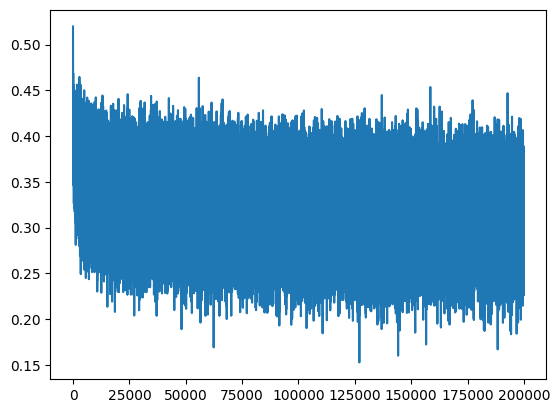

In [16]:
plt.plot(list(map(lambda x: x.log10().item(), losstrn)))

Function to calculate loss on given dataset

In [17]:
@torch.no_grad
def getloss(X, Y):
    emb = C[X]
    hpreact = emb.view((-1, block_size*dims)) @ W1
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss

### Print the loss on the training, validation and testing datasets

In [18]:
print(f"Training Loss: {getloss(Xtrn, Ytrn).item()}")
print(f"Validation Loss: {getloss(Xdev, Ydev).item()}")
print(f"Testing Loss: {getloss(Xtst, Ytst).item()}")

Training Loss: 2.059807538986206
Validation Loss: 2.123396873474121
Testing Loss: 2.1159324645996094


### Histogram of Neurons' Weights

(array([1311.,  481.,  273.,  308.,  191.,  180.,  162.,  158.,  213.,
         160.,  136.,  121.,  140.,  143.,   81.,   59.,   80.,   84.,
          67.,   96.,   75.,   65.,   85.,   84.,   63.,   81.,   68.,
          64.,   64.,  109.,  112.,  108.,  148.,  128.,   84.,   90.,
          98.,  105.,  106.,  124.,  130.,  163.,  181.,  225.,  229.,
         182.,  254.,  352.,  392., 1187.]),
 array([-9.99997497e-01, -9.59997581e-01, -9.19997666e-01, -8.79997751e-01,
        -8.39997835e-01, -7.99997920e-01, -7.59998004e-01, -7.19998089e-01,
        -6.79998174e-01, -6.39998258e-01, -5.99998343e-01, -5.59998428e-01,
        -5.19998512e-01, -4.79998597e-01, -4.39998682e-01, -3.99998766e-01,
        -3.59998851e-01, -3.19998935e-01, -2.79999020e-01, -2.39999105e-01,
        -1.99999189e-01, -1.59999274e-01, -1.19999359e-01, -7.99994433e-02,
        -3.99995279e-02,  3.87430191e-07,  4.00003028e-02,  8.00002182e-02,
         1.20000134e-01,  1.60000049e-01,  1.99999964e-01,  2.399998

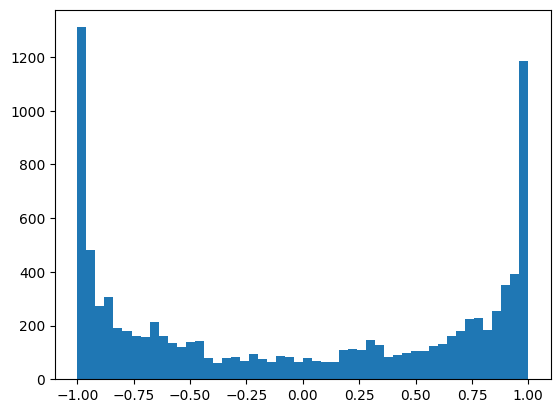

In [19]:
plt.hist(h.view(-1).tolist(), bins=50)

### Visualising dead neurons

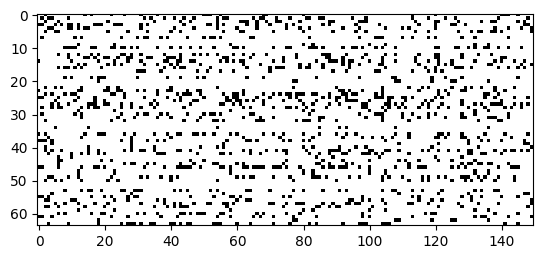

In [25]:
plt.imshow(h.abs() < 0.99, cmap='gray', interpolation='nearest')

### Function to generate a new word based using current model

In [26]:
@torch.no_grad
def generate():
    op = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        hpreact = emb.view((1, -1)) @ W1
        hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        nxti = torch.multinomial(probs, num_samples=1).item()
        if nxti == 0: return ''.join([itoc[x] for x in op])
        context = context[1:] + [nxti]
        op.append(nxti)

### Generate and print 20 samples

In [28]:
for _ in range(20): print(generate())

kae
ron
urelis
shery
kayssah
nee
safrander
kay
dannir
solynmi
jean
cord
tamisiden
mylandavis
ali
jens
krhilda
gen
betson
janta
